# Deep Neural Network for Steering Direction Classification

## Building Blocks:
1. Importing packages
2. Loading and preprocessing data
3. Functions

| Function name | Parameters | Output | Description |
|:------------- | ---------- | ------ | -----------:|
| initialise_params | List: layers_dims | Dict: parameters | initialise parameters w and b according to g[l]|
| forward | Array: A_prev <br> Array: W <br> Array: b <br> String: activation | Array: A <br> Tuple: cache | compute activation output for each layer |
| forward_propagation | Array: X<br>Dict: parameters | Array: AL<br>Tuple: caches | forward propagate |
| compute_cost | Array: AL<br>Array: Y | Float: cost | compute cost |
| backward | Array: dA<br>Tuple: cache<br>String: activation | Array: dA_prev<br>Array: dW<br>Array: db | compute gradients for each layer |
| backward_propagation | Array: AL<br>Array: Y<br>Tuple: caches | Dict: grads | backward propagation |
| update_parameters | Dict: parameters<br>Dict: grads<br>Float: learning_rate | Dict: parameters | update parameters |
   

## Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.preprocessing import image

Using TensorFlow backend.


## Loading and preprocessing pixel data

In [1]:
for i in range(400):
    img = image.load_img("Data_trial/" + str(i) + "_crop.jpg", target_size = (60, 80))
    img_array = image.img_to_array(img)
    image_flat = img_array.reshape(img_array.shape[0]*img_array.shape[1]*img_array.shape[2],1)
    if(i == 0):
        X = np.zeros((img_array.shape[0]*img_array.shape[1]*img_array.shape[2],400))
    X[:,i] = image_flat[:,0] 

X = X/255.

yvals = pd.read_excel('Data_trial/data_trial.xlsx',sheet_name = 'Sheet1',nrows = 400)
y = yvals.values[:,1].reshape(yvals.values[:,1].shape[0],1).T # y.shape = (1,400)
Y = np.zeros((3, y.shape[1]))  # three classes, so Y for each example should be 3*1
for i in range(y.shape[1]):
    Y[int(y[0,i]),i] = 1

X_train = X[:, 0:320]
Y_train = Y[:, 0:320]
X_dev = X[:, 320: 360]
Y_dev = Y[:, 320: 360]
X_test = X[:, 360: 400]
Y_test = Y[:, 360: 400]

NameError: name 'image' is not defined

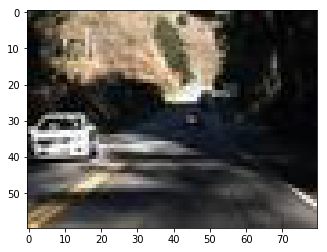

In [5]:
plt.imshow(X_dev[:, 1].reshape(60,80,3))

## Loading and preprocessing DVS data

In [75]:
for i in range(400):
    img = image.load_img("Data_DVS/" + str(i) + ".png", target_size = (60, 80))
    img_array = image.img_to_array(img)
    image_flat = img_array.reshape(img_array.shape[0]*img_array.shape[1]*img_array.shape[2],1)
    if(i == 0):
        X = np.zeros((img_array.shape[0]*img_array.shape[1]*img_array.shape[2],400))
    X[:,i] = image_flat[:,0] 

X = X/255.

yvals = pd.read_excel('Data_trial/data_trial.xlsx',sheet_name = 'Sheet1',nrows = 400)
y = yvals.values[:,1].reshape(yvals.values[:,1].shape[0],1).T # y.shape = (1,400)
Y = np.zeros((3, y.shape[1]))  # three classes, so Y for each example should be 3*1
for i in range(y.shape[1]):
    Y[int(y[0,i]),i] = 1

X_train = X[:, 0:100]
Y_train = Y[:, 0:100]
X_dev = X[:, 320: 360]
Y_dev = Y[:, 320: 360]
X_test = X[:, 360: 400]
Y_test = Y[:, 360: 400]

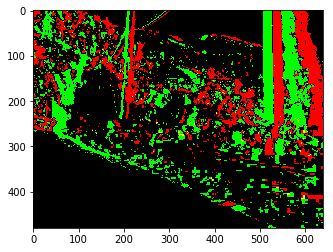

In [74]:
plt.imshow(X_dev[:, 5].reshape(60,80,3))

## Function: initialising_parameters

In [6]:
def initialise_parameters(layers_dims):
    """
    This function initialises parameters using modified Xavier's initialisation technique
    """
    parameters = {}
    
    L = len(layers_dims) - 1 #number of layers
    for l in range(1, L+1):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l],1))
    
    return parameters

## Function: forward

In [7]:
def forward(A_prev, W, b, activation, keep_prob):
    """
    This function computes linear + activation for a single layer and adds dropout regularisation. 
    To be used for forward propagation with dropout
    """
    
    Z = np.dot(W, A_prev) + b  # linear part
    
    if(activation == "relu"):
        A = np.maximum(Z, 0)  # implementing relu activation
    elif(activation == "tanh"):
        A = np.tanh(Z)  # implementing tanh activation
    elif(activation == "sigmoid"):
        A = 1./(1+np.exp(-Z))  # implementing sigmoid activation
        
    # now add dropout
    D = np.random.rand(A.shape[0],A.shape[1])
    D = D < keep_prob
    A = A * D
    A = A / keep_prob
    
    assert(Z.shape == (W.shape[0], A_prev.shape[1]))
    assert(A.shape == Z.shape)
    
    cache = (A_prev, W, b, Z, D)
    
    return A, cache

## Function: forward_propagation

In [8]:
def forward_propagation(X, parameters, keep_prob):
    """
    This function performs forward propagation to compute predicted final output with drop out implemented. 
    Activations for all nodes before output layer is relu, and output activation is sigmoid (one-vs-all)
    """
    
    L = len(parameters) // 2  # number of layers
    A = X
    caches = []
    
    for l in range(1, L):
        A_prev = A  # output of layer l is input for layer l+1
        A, cache = forward(A_prev, parameters["W"+str(l)], parameters['b'+str(l)], "relu", keep_prob)
        caches.append(cache)  # storing all A, W, b and Z for later use in backprop
        
    AL, cache = forward(A, parameters["W"+str(L)], parameters['b'+str(L)], "sigmoid", keep_prob)
    caches.append(cache)
      # output of layer L, predictions
    
    return AL, caches

## Function: compute_cost
**formula:**
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) $$

In [9]:
def compute_cost(AL, Y):
    """
    This function computes cost for examples using above formula
    
    Output J should be of shape (1, m)
    """
    
    m = Y.shape[1]  # number of examples
    num_labels = Y.shape[0]  # number of labels
    cost = 0.
    
    for k in range(num_labels):
        cost += (-1/m) * (np.dot(Y[k,:], np.log(AL[k,:].T)) + np.dot((1-Y[k,:]), np.log(1-AL[k,:].T)))
    
    return cost

## Function: compute_cost_with_L2
**formula:**
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [10]:
def compute_cost_with_L2(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    
    m = Y.shape[1]
    L = len(parameters) // 2
    
    cross_entropy_cost = compute_cost(AL, Y)
    
    L2_cost = 0
    for l in range(1, L + 1):
        L2_cost += np.sum(np.square(parameters["W" + str(l)]))
                
    L2_cost = (1/m) * (lambd/2) * L2_cost 
                       
    cost = cross_entropy_cost + L2_cost

    return cost                      

## Function: backward

In [11]:
def backward(dA, cache, cache_prev, activation, keep_prob, lambd):
    """
    This function computes dW and db and other derivatives for backward prop of a single layer
    """
    
    A_prev, W, b, Z, _ = cache  # retrieving variables for computing derivatives
    _, __, ___, ____, D_prev = cache_prev
    
    m = A_prev.shape[1]  # number of examples
    
    if(activation == "relu"):
        relu_derivative_Z = np.copy(Z)
        relu_derivative_Z[relu_derivative_Z > 0] = 1
        relu_derivative_Z[relu_derivative_Z <= 0] = 0
        dZ = dA * relu_derivative_Z
    elif(activation == "tanh"):
        A = np.tanh(Z)
        dZ = dA * (1 - np.square(A))
    elif(activation == "sigmoid"):
        A = 1./(1+np.exp(-Z))
        dZ = dA * (A * (1-A))
    
    dW = 1/m * np.dot(dZ, A_prev.T) + lambd/m * W
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    ## Add dropout here
    dA_prev = dA_prev * D_prev
    dA_prev = dA_prev / keep_prob
    
    assert(dW.shape == W.shape)
    assert(db.shape == (W.shape[0],1))
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev, dW, db

## Function: backward_propagation

In [12]:
def backward_propagation(AL, Y, caches, keep_prob, lambd):
    """
    This function performs backward propagation and returns values of all gradients w.r.t W and b
    """
    
    grads = {}
    L = len(caches)  # each element of List caches is a tuple cache for each layer
    
    # back propagation for the last layer, with sigmoid activation
    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # compute dAL for output layer
    dA_prev, dW, db = backward(dAL, caches[L-1], caches[L-2], "sigmoid", keep_prob, lambd)
    grads["dA"+str(L-1)] = dA_prev
    grads["dW"+str(L)] = dW
    grads["db"+str(L)] = db
    
    # back propagation for previous layers except the first, for which there was not dropout
    for l in reversed(range(2, L)):
        dA = dA_prev
        dA_prev, dW, db = backward(dA, caches[l-1], caches[l-2], "relu", keep_prob, lambd)
        grads["dA"+str(l-1)] = dA_prev
        grads["dW"+str(l)] = dW
        grads["db"+str(l)] = db
    
    dA = dA_prev
    D0 = np.ones((caches[0][0].shape))
    dA_prev, dW, db = backward(dA, caches[0], (0,0,0,0,D0) , "relu", keep_prob = 1, lambd = lambd)
    grads["dA"+str(0)] = dA_prev
    grads["dW"+str(1)] = dW
    grads["db"+str(1)] = db
    
    
    return grads

## Function: initialise_adam

In [13]:
def initialise_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros((parameters["W"+str(l+1)].shape[0],parameters["W"+str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b"+str(l+1)].shape[0],parameters["b"+str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W"+str(l+1)].shape[0],parameters["W"+str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b"+str(l+1)].shape[0],parameters["b"+str(l+1)].shape[1]))
    ### END CODE HERE ###
    
    return v, s

## Function: update_parameters_with_adam

In [14]:
def update_parameters_with_adam(parameters, grads,  v, s, t, learning_rate, 
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2  # number of layers
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1-beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1-beta1) * grads["db" + str(l+1)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
#         s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.square(grads["dW" + str(l+1)])
#         s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.square(grads["db" + str(l+1)])

#         # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
#         s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2**t)
#         s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)]# / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)]# / (np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)
        
    return parameters, v, s

## Model 1

In [15]:
def NN_model_1(X, Y, layers_dims, learning_rate, num_epochs = 1000, print_cost = True, keep_prob = 1, lambd = 0.7):
    """
    This is the first deep learning model. 
    """
    
    costs = [];
    
    #initialise paramters
    parameters = initialise_parameters(layers_dims)
    v, s = initialise_adam(parameters)
    
    #implement batch gradient descent
    for i in range(0, num_epochs):
        #forward propagation
        AL, caches = forward_propagation(X, parameters, keep_prob)

        #compute costs
        cost = compute_cost_with_L2(AL, Y, parameters, lambd)
        
        #backward propagation
        grads = backward_propagation(AL, Y, caches, keep_prob, lambd)
        
        #update parameters
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, (i+1), learning_rate, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8)
        
        if(print_cost and i % 50 == 0):
            print("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 2.606761
Cost after iteration 50: 1.132852
Cost after iteration 100: 0.927450
Cost after iteration 150: 0.815851
Cost after iteration 200: 0.734219
Cost after iteration 250: 0.667326
Cost after iteration 300: 0.602178
Cost after iteration 350: 0.526006


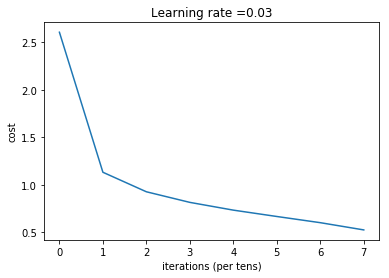

In [90]:
layers_dims = [14400, 20, 5, 3]
parameters = NN_model_1(X_train, Y_train, layers_dims, learning_rate = 0.03, num_epochs=400, keep_prob = 1, lambd = 2)


## Function: predict

In [19]:
def predict(X, Y, parameters):
    """
    This function makes predictions on input X using input parameters, and returns accuracy
    """
    
    AL, _ = forward_propagation(X, parameters, keep_prob = 1)
    
    for i in range(AL.shape[1]):
        AL_i = AL[:, i]
        max_prob = np.amax(AL_i)
        AL_i[AL_i >= max_prob] = 1
        AL_i[AL_i < max_prob] = 0
        AL[:, i] = AL_i

    correct = 0.
    errors = []
    
    for i in range(Y.shape[1]):
        if(np.array_equal(AL[:,i], Y[:,i])):
            correct += 1
        else:
            errors.append((i, AL[:,i], Y[:,i]))
            
    accuracy = correct / Y.shape[1]
    
    return accuracy, errors

In [91]:
accuracy_train, errors_train = predict(X_train, Y_train, parameters)
accuracy_dev, errors_dev = predict(X_dev, Y_dev, parameters)
accuracy_test, errors_test = predict(X_test, Y_test, parameters)
print(accuracy_train)
print(accuracy_dev)
print(accuracy_test)

1.0
0.725
0.675


In [49]:
for i in range(len(errors_train)):
    print("index: " + str(errors_train[i][0]))
    print("predicted: " + str(errors_train[i][1]))
    print("correct: " + str(errors_train[i][2]))

In [79]:
for i in range(len(errors_dev)):
    print("index: " + str(320 + errors_dev[i][0]))
    print("predicted: " + str(errors_dev[i][1]))
    print("correct: " + str(errors_dev[i][2]))

index: 325
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 327
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 328
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 329
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 333
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 337
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 339
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 348
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 351
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 353
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 355
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 357
predicted: [0. 1. 0.]
correct: [1. 0. 0.]


In [78]:
for i in range(len(errors_test)):
    print("index: " + str(360 + errors_test[i][0]))
    print("predicted: " + str(errors_test[i][1]))
    print("correct: " + str(errors_test[i][2]))

index: 360
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 362
predicted: [1. 0. 0.]
correct: [0. 1. 0.]
index: 366
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 368
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 373
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 376
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 378
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 381
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 382
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 383
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 386
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 388
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 389
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
index: 394
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 397
predicted: [0. 1. 0.]
correct: [1. 0. 0.]
index: 399
predicted: [0. 1. 0.]
correct: [0. 0. 1.]
